In [11]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

device = 'cpu'

We want to see how the morphology of the network affects the speed of learning. 

For this we have trained 6 different dendritic architectures that differ in their width/depth. We want to keep the total number of parameters roughly the same across all networks, so as we increase network depth we also decrease network width. 

We trained 4 instances of the same model. The first instance of a 2 layer network has the name: `unconditional-dendritic-2-layers_1`. 

In [12]:
from utils import select_model

list_of_layer_depths = [2, 4, 5, 6, 7, 10]  # number of layers
list_of_models = ['unconditional-dendritic-' + str(l) + '-layers' for l in list_of_layer_depths]
print(list_of_models)

from utils import load_model_weights_from_chkpt
model, num_steps, ambient_dims = load_model_weights_from_chkpt(list_of_models[0], model_num=1, epoch_number=0)
print(model)

['unconditional-dendritic-2-layers', 'unconditional-dendritic-4-layers', 'unconditional-dendritic-5-layers', 'unconditional-dendritic-6-layers', 'unconditional-dendritic-7-layers', 'unconditional-dendritic-10-layers']
model loaded!
VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6962, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
  )
)


now load the first instance of each architecture

In [13]:
epoch_number = 1490000

models = []
for model in list_of_models:
    model, num_steps, ambient_dims = load_model_weights_from_chkpt(model, model_num=1, epoch_number=epoch_number)
    models.append(model)

model loaded!
model loaded!
model loaded!
model loaded!
model loaded!
model loaded!


see how the generated samples look like after 15e5 training epochs, sorted by number of dendritic layers

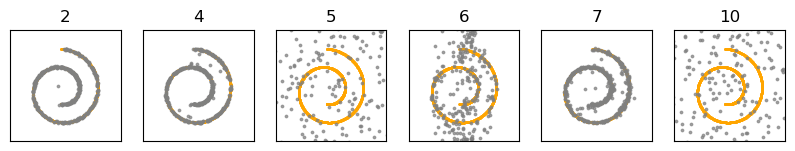

In [15]:
# now generate samples from all models for a given epoch
temp = 100
lim = 1.5
lims = [-lim, lim]
sample_size = int(5e2)
from prior_utils import p_sample_loop
from dataset_utils import generate_2d_swiss_roll
gt_manifold = generate_2d_swiss_roll(int(1e3), True, return_as_tensor=True)[1]

fig, ax = plt.subplots(1, len(models), figsize=(10,2))
for i, model in enumerate(models):
    x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
    
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*x_rev[-1].T, s=3, alpha=0.7, color='grey')
    ax[i].set(title=f'{list_of_layer_depths[i]}')
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xlim=lims, ylim=lims)
        remove_all_ticks_and_labels(a)
    

We want to see whether the morphology of the architecture affects the speed at which the network is able to learn the underlying dataset. 

We generated many samples from each network throughout their learning process. We can quantify how well they've learned the distribution by calculating the KL divergence between the ground truth manifold and the generated samples. The higher the KL divergence, the less similar the generated samples are to the ground truth dataset. 

In [16]:
import zarr

data_base_dir = os.path.join(base_dir, 'core/saved_arrays')

eval_epochs = [i for i in range(0, int(15e5), int(1e5))]
eval_epochs.append(int(15e5-1e4))

skip the below

In [32]:
def load_samples_from_file(depth, model_iteration, chkpt_num):
    data_dir = os.path.join(data_base_dir, 'samples', f'unconditional-dendritic-{depth}-layers_{model_iteration}', 'by_checkpoints', str(chkpt_num), 'prior-iid-unimodal')
    samples = zarr.load(os.path.join(data_dir, 'num_samples=5e+04-num_runs=1-batch_idx=0', 'x_revs-run_num=0.zarr'))
    return samples

instance = 1

for chkpt_num in eval_epochs:
    print('epoch', chkpt_num)
    samples_by_depth = []
    for depth in list_of_layer_depths:
        print('    depth', depth)
        samples_by_instance = []
        for instance in range(1, 5):
            samples = load_samples_from_file(depth, instance, chkpt_num)
            samples_by_instance.append(samples)
        samples_by_instance = np.stack(samples_by_instance)
        samples_by_depth.append(samples_by_instance)
    samples_by_depth = np.stack(samples_by_depth)
    zarr.save(os.path.join(data_base_dir, 'morphology', f'epoch={chkpt_num}'), samples_by_depth)
    print(f'epoch {chkpt_num} saved!')

epoch 0
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 0 saved!
epoch 100000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 100000 saved!
epoch 200000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 200000 saved!
epoch 300000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 300000 saved!
epoch 400000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 400000 saved!
epoch 500000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 500000 saved!
epoch 600000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 600000 saved!
epoch 700000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 700000 saved!
epoch 800000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 800000 saved!
epoch 900000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 900000 saved!
epoch 1000000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 1000000 saved!
epoch 1100000
depth 2
depth 4
depth 5
depth 6
depth 7
depth 10
epoch 1100000 saved!
epoch 1200000
depth 2


In [38]:
for chkpt_num in eval_epochs:
    print(chkpt_num)
    data_dir = os.path.join(data_base_dir, 'morphology_all')
    samples = zarr.load(os.path.join(data_dir, f'epoch={chkpt_num}'))
    samples_last_idx = samples[:, :, 100, :, :]
    zarr.save(os.path.join(data_base_dir, 'morphology', f'epoch={chkpt_num}'), samples_last_idx)

0


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1490000


Ignore the above

In [28]:
# now calculate the KL divergence between the generated samples and the ground truth dataset
from likelihood_utils import calculate_histogram
num_bins_per_dim = 15
domain_range = 3

# 5e3 samples per model

histograms_by_epoch = []
for epoch in eval_epochs:
    print(epoch)
    data_dir = os.path.join(data_base_dir, 'morphology')
    samples = zarr.load(os.path.join(data_dir, f'epoch={epoch}'))
    # samples has shape (depths: 6, iterations: 4, samples: 50000, dimensions: 2)

    # now calculate the histogram of samples from the prior
    histogram_by_depth = []
    for d, depth in enumerate(list_of_layer_depths):
        histogram_by_iteration = []
        for i in range(4):
            histogram = calculate_histogram(samples[d, i], num_bins_per_dim, domain_range)
            histogram_by_iteration.append(histogram)
        histogram_by_iteration = np.stack(histogram_by_iteration)
        histogram_by_depth.append(histogram_by_iteration)
    histogram_by_depth = np.stack(histogram_by_depth)
    histograms_by_epoch.append(histogram_by_depth)
histograms_by_epoch = np.stack(histograms_by_epoch)
print(histograms_by_epoch.shape)
# zarr.save(os.path.join(), histogram_by_depth)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1490000
(16, 6, 4, 15, 15)


In [29]:
from dataset_utils import generate_2d_swiss_roll
num_samples_in_gt_manifold = 5e4
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]
histogram_of_dataset = calculate_histogram(dataset, num_bins_per_dim, domain_range)
print(histogram_of_dataset.shape)

(15, 15)


In [30]:
from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

kl_by_epoch = []
for e, epoch in enumerate(eval_epochs):
    # histograms_by_epoch has shape (epochs: 16, depths: 6, iterations: 4, dim1: 15, dim2: 15)

    kl_by_depth = []
    for d, depth in enumerate(list_of_layer_depths):

        kl_by_iteration = []
        for i in range(4):
            # ------------------------------------ iid ----------------------------------- #
            p = histograms_by_epoch[e, d, i] + epsilon  # distribution of model generated samples 
            q = histogram_of_dataset + epsilon  # distribution to compare against

            p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
            q = q.flatten() / np.sum(q)  # turn into a vector and then normalize
            kl_by_iteration.append(entropy(p, q))
        kl_by_iteration = np.stack(kl_by_iteration)
        kl_by_depth.append(kl_by_iteration)
    kl_by_depth = np.stack(kl_by_depth)
    kl_by_epoch.append(kl_by_depth)
kl_by_epoch = np.stack(kl_by_epoch)

print(kl_by_epoch.shape)




(16, 6, 4)


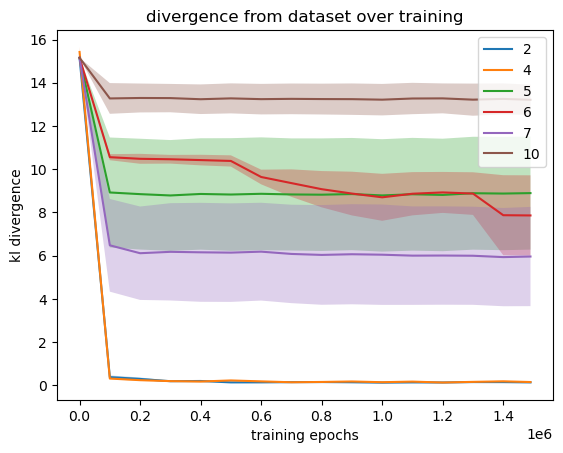

In [31]:
fig, ax = plt.subplots(1, 1)
x = eval_epochs

kl_mean = np.mean(kl_by_epoch, axis=2)
kl_stdev = np.std(kl_by_epoch, axis=2) / np.sqrt(4)
for i in range(len(list_of_layer_depths)):
    ax.plot(eval_epochs, kl_mean[:, i], label=f'{list_of_layer_depths[i]}')
    ax.fill_between(eval_epochs, kl_mean[:,i]+kl_stdev[:,i], kl_mean[:,i]-kl_stdev[:,i], alpha=0.3)
ax.legend()
ax.set(ylabel='kl divergence', xlabel='training epochs', title='divergence from dataset over training')

from plot import save_fig
save_fig(fig, 'supp-morphology')